# Assignment 3

## 1. Selecting an Appropriate Dataset

### 1.1. About the Dataset
The dataset contains transactions made by credit cards in September 2013 by European cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Due to confidentiality issues, the original features and more background information about the data was not provided. 

Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. 

Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

### 1.2. Download the Dataset 

In [1]:
# !gdown 1eKJz8DSnPDpcenkzWJxFsA_WoNAwV6HP

### 1.3. Read the dataset

In [1]:
# imports and some settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib
matplotlib.rcParams['figure.figsize'] = (15, 8)

In [2]:
# read and have a look at the data
df = pd.read_csv('dataset2.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# classes and no. of examples per class
y = df['Class']
print("no. of examples per class:\n{}".format(y.value_counts()))
y = y.values

# dimensionality of the feature vectors
X = df.iloc[:, 1:-1]
print("number of samples vs. features: {}".format(X.shape))
X = X.values

no. of examples per class:
0    284315
1       492
Name: Class, dtype: int64
number of samples vs. features: (284807, 29)


## 2. Data Preparation

1. **Linear Detrending:** 
Remove linear trends from the data; involves fitting a straight line to each of the features via linear regression and then taking the residuals as the new feature values. We do this because we don't want our machine learning algorithm to get biased by any such linear trends.

2. **Normalization:** 
Feature-wise z-scoring; by removing the mean and scaling to unit variance. The removal of mean is very important because some classifiers really get affected/biased by data having large offsets.

In [4]:
# imports and settings
from scipy.signal import detrend
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
RANDOM_STATE = 4321

In [5]:
# a scikit-learn like transformer for feature-wise linear detrender
class LinearDetrend(BaseEstimator, TransformerMixin):
    """based on sklearn; for feature-wise linear detrending"""
    
    def __init__(self, axis = 0): # default: detrending along columns
        self.axis = axis
    
    def fit(self, X, y = None):
        return self 
    
    def transform(self, X, y = None):
        return detrend(X, axis = self.axis)

## 3, 4 and 5. Data Modeling, Evaluation and Comparison
Since it is a highly imbalanced dataset, and the skew in the class distribution can influence many machine learning algorithms, we are going to randomly resample the training set and rebalance the class distribution before giving it to a classifier. We can achieve that either by:
1. _over-sampling_ the minority class, or 
2. _undersampling_ the majority class.

Although here I am going to use just one oversampling and one undersampling method, there are many of these (see [oversampling](https://imbalanced-learn.org/stable/references/over_sampling.html) and [undersampling](https://imbalanced-learn.org/stable/references/under_sampling.html#)), each with its own pros and cons.

In [6]:
from imblearn.over_sampling import SMOTE  # N. V. Chawla et al. 2002

from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler 
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix

In [14]:
def balance_data(
    X, y,
    method,
    random_state,
) -> tuple:
    """
    Balance data based on over-sampling or under-sampling.
    """
    if method == 'over':
        over_sampler = SMOTE(random_state=random_state)
        X, y = over_sampler.fit_resample(X, y)
    elif method == 'under':
        under_sampler = RandomUnderSampler(random_state=random_state)
        X, y = under_sampler.fit_resample(X, y)
    return X, y


def evaluate_classifier(
    classifier,
    X, y,
    balancing_method,
    cross_validator,
    random_state,
) -> tuple:
    """
    Evaluate the classifier based on evaluation measures including recall,
    precision, f1-score and confusion matrix.
    """
    train_recall, train_precision, train_f1, train_confusion = [], [], [], []
    test_recall, test_precision, test_f1, test_confusion = [], [], [], []
    for train_index, test_index in cross_validator.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # preprocess data
        preprocessor = make_pipeline(LinearDetrend(), StandardScaler())
        X_train = preprocessor.fit_transform(X_train)
        X_test =  preprocessor.fit_transform(X_test)

        # use over-sampling of minority or under-sampling of majority class
        # to balance the classes
        X_train, y_train = balance_data(X_train, y_train, balancing_method, random_state)

        # fit the classifier
        classifier.fit(X_train, y_train)
        
        # infer the labels of the training and test set
        y_pred_train = classifier.predict(X_train)
        y_pred_test = classifier.predict(X_test)

        # evaluate performance based on different metrics
        # first on the training set
        train_recall.append(recall_score(y_train, y_pred_train))
        train_precision.append(precision_score(y_train, y_pred_train))
        train_f1.append(f1_score(y_train, y_pred_train))
        train_confusion.append(confusion_matrix(y_train, y_pred_train))

        # then on the test set
        test_recall.append(recall_score(y_test, y_pred_test))
        test_precision.append(precision_score(y_test, y_pred_test))
        test_f1.append(f1_score(y_test, y_pred_test))
        test_confusion.append(confusion_matrix(y_test, y_pred_test))
    
    # finally, return the scores for visualization purposes etc.
    return (
        (
            (np.mean(train_recall, axis=0), np.std(train_recall, axis=0)),
            (np.mean(train_precision, axis=0), np.std(train_precision, axis=0)),
            (np.mean(train_f1, axis=0), np.std(train_f1, axis=0)),
            (np.mean(train_confusion, axis=0), np.std(train_confusion, axis=0)),
        ), 
        (
            (np.mean(test_recall, axis=0), np.std(test_recall, axis=0)),
            (np.mean(test_precision, axis=0), np.std(test_precision, axis=0)),
            (np.mean(test_f1, axis=0), np.std(test_f1, axis=0)),
            (np.mean(test_confusion, axis=0), np.std(test_confusion, axis=0)),
        ), 
    )

In [15]:
cv = RepeatedStratifiedKFold(
    n_splits=5,
    n_repeats=3,
    random_state=RANDOM_STATE,
)
classifiers = {
    'SVM': LinearSVC(random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE),
    'Gradient Boosting Classifier': GradientBoostingClassifier(random_state=RANDOM_STATE),
}

os_results = {}
us_results = {}
for classifier_type, classifier in classifiers.items():
    print(f'Evaluating the performance of {classifier_type}.')
    os_results[classifier_type] = evaluate_classifier(  # over-sampling
        classifier, X, y, 'over', cv, RANDOM_STATE,
    )
    us_results[classifier_type] = evaluate_classifier(  # under-sampling
        classifier, X, y, 'under', cv, RANDOM_STATE,
    )

Evaluating the performance of SVM.


/usr/local/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warning

Evaluating the performance of Random Forest.
Evaluating the performance of Gradient Boosting Classifier.


In [26]:
def tabulate_results(results: dict) -> list:
    """Tabulate the results dictionary, for ease of plotting using seaborn."""
    results_table = []
    for classifier_type in os_results:
        train_rec, train_prec, train_f1, train_conf = results[classifier_type][0]
        test_rec, test_prec, test_f1, test_conf = results[classifier_type][1]
        results_table.append([classifier_type, 'training data', 'recall', train_rec[0]])
        results_table.append([classifier_type, 'training data', 'precision', train_prec[0]])
        results_table.append([classifier_type, 'training data', 'f1', train_f1[0]])
        results_table.append([classifier_type, 'training data', 'confusion', train_conf[0]])
        results_table.append([classifier_type, 'test data', 'recall', test_rec[0]])
        results_table.append([classifier_type, 'test data', 'precision', test_prec[0]])
        results_table.append([classifier_type, 'test data', 'f1', test_f1[0]])
        results_table.append([classifier_type, 'test data', 'confusion', test_conf[0]])
    return results_table

## Oversampling Results

In [36]:
os_table = tabulate_results(os_results)
without_conf = [row for row in os_table if row[2] != 'confusion']

os_df = pd.DataFrame(
    without_conf, 
    columns=['classifier', 'dataset', 'metric', 'performance'],
)
print(os_df)

                      classifier        dataset     metric  performance
0                            SVM  training data     recall     0.907956
1                            SVM  training data  precision     0.976653
2                            SVM  training data         f1     0.941045
3                            SVM      test data     recall     0.906507
4                            SVM      test data  precision     0.067575
5                            SVM      test data         f1     0.125699
6                  Random Forest  training data     recall     1.000000
7                  Random Forest  training data  precision     1.000000
8                  Random Forest  training data         f1     1.000000
9                  Random Forest      test data     recall     0.814354
10                 Random Forest      test data  precision     0.879400
11                 Random Forest      test data         f1     0.844852
12  Gradient Boosting Classifier  training data     recall     0

Text(0.5, 1.0, 'Classifier Comparison using the Training Data')

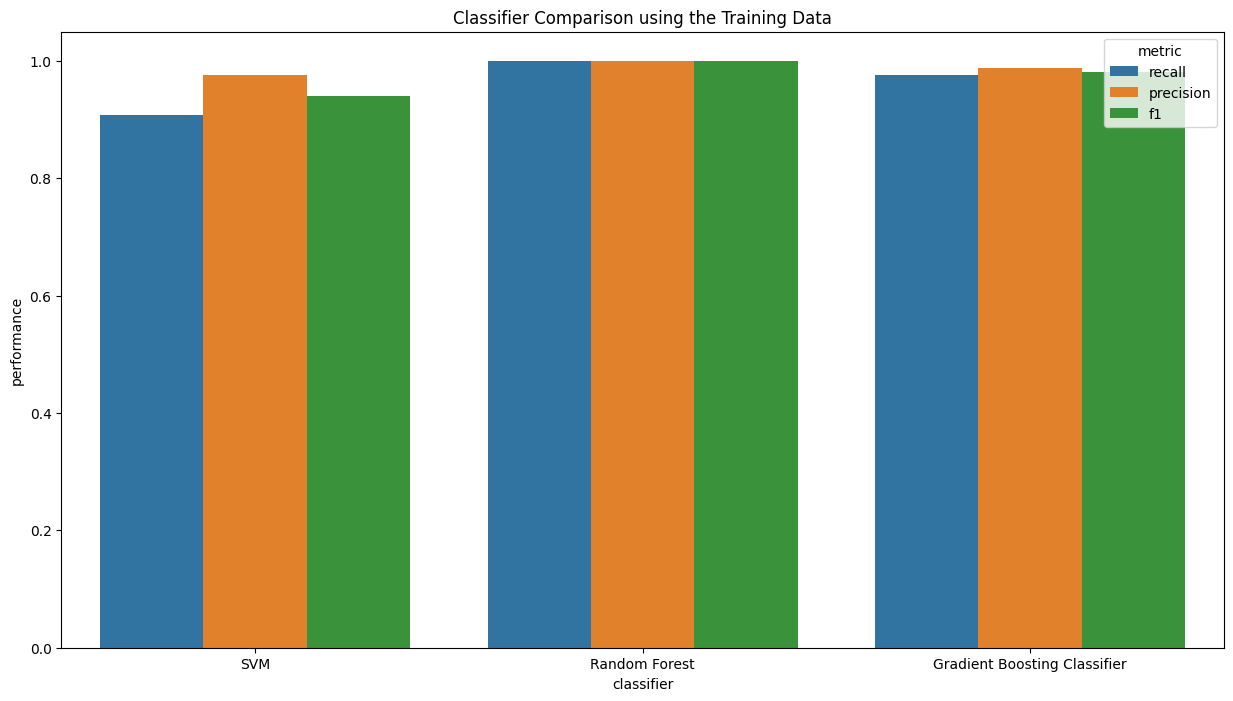

In [33]:
plt.figure()
sns.barplot(data=os_df[os_df.dataset == 'training data'], x='classifier', y='performance', hue='metric')
plt.title('Classifier Comparison using the Training Data')

Text(0.5, 1.0, 'Classifier Comparison using the Test Data')

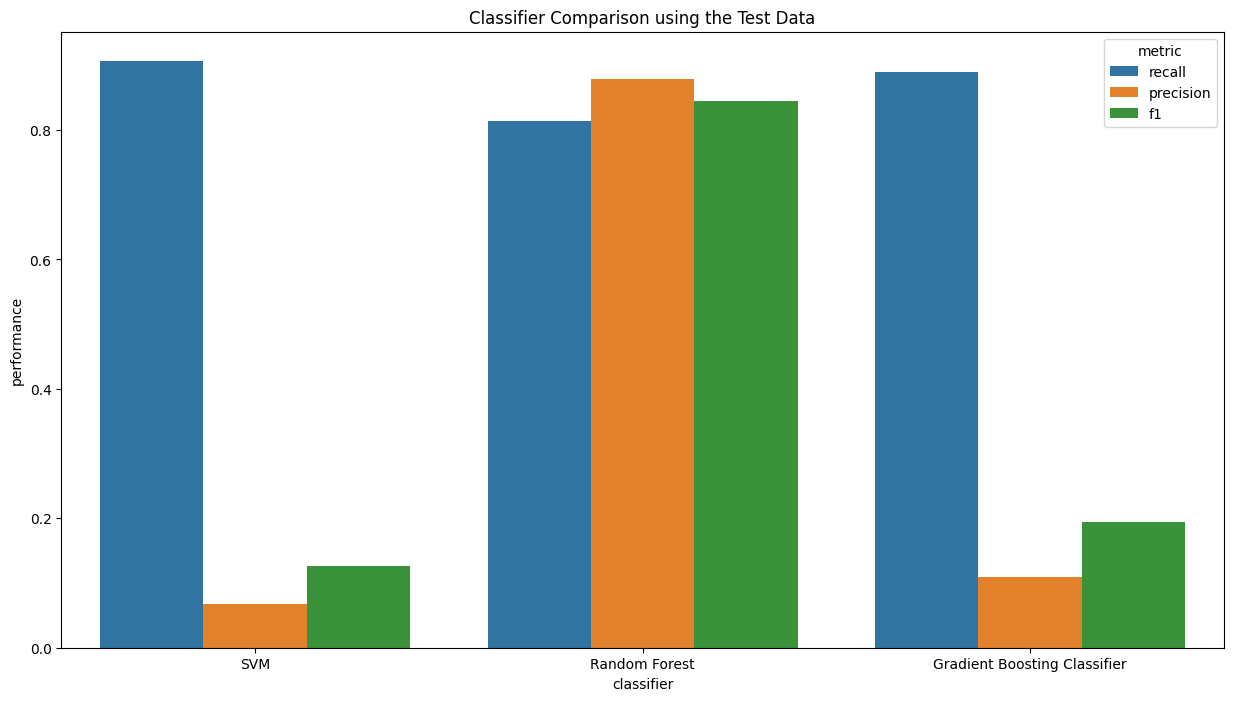

In [34]:
plt.figure()
sns.barplot(data=os_df[os_df.dataset == 'test data'], x='classifier', y='performance', hue='metric')
plt.title('Classifier Comparison using the Test Data')

## Undersampling Results

In [37]:
us_table = tabulate_results(us_results)
without_conf = [row for row in us_table if row[2] != 'confusion']

us_df = pd.DataFrame(
    without_conf, 
    columns=['classifier', 'dataset', 'metric', 'performance'],
)
print(us_df)

                      classifier        dataset     metric  performance
0                            SVM  training data     recall     0.919377
1                            SVM  training data  precision     0.981733
2                            SVM  training data         f1     0.949520
3                            SVM      test data     recall     0.912609
4                            SVM      test data  precision     0.049502
5                            SVM      test data         f1     0.093760
6                  Random Forest  training data     recall     1.000000
7                  Random Forest  training data  precision     1.000000
8                  Random Forest  training data         f1     1.000000
9                  Random Forest      test data     recall     0.901099
10                 Random Forest      test data  precision     0.057344
11                 Random Forest      test data         f1     0.107655
12  Gradient Boosting Classifier  training data     recall     0

Text(0.5, 1.0, 'Classifier Comparison using the Training Data')

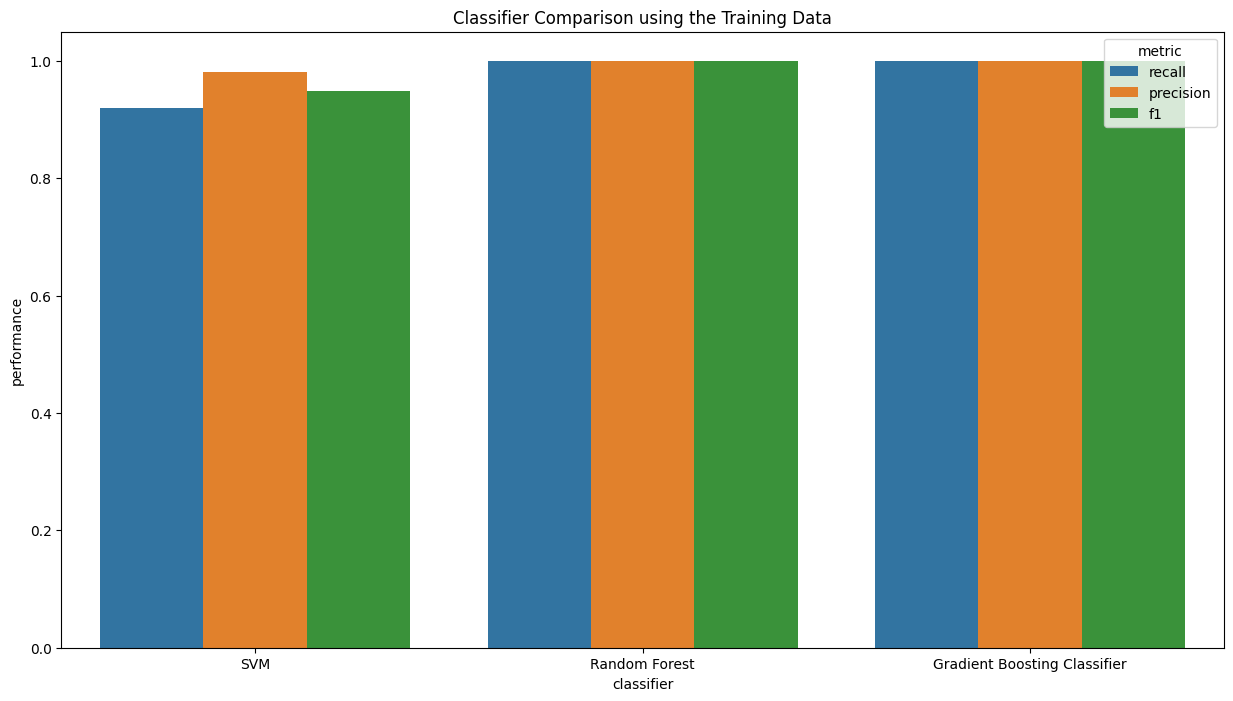

In [40]:
plt.figure()
sns.barplot(data=us_df[us_df.dataset == 'training data'], x='classifier', y='performance', hue='metric')
plt.title('Classifier Comparison using the Training Data')

Text(0.5, 1.0, 'Classifier Comparison using the Test Data')

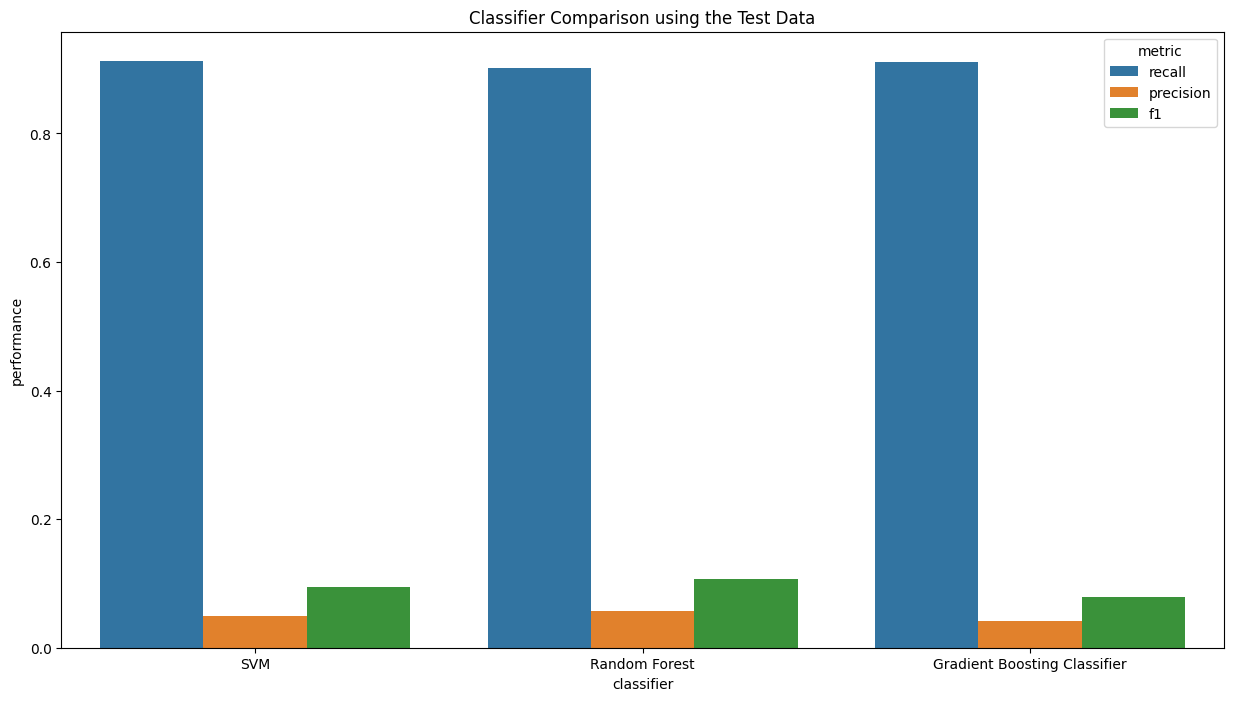

In [41]:
plt.figure()
sns.barplot(data=us_df[us_df.dataset == 'test data'], x='classifier', y='performance', hue='metric')
plt.title('Classifier Comparison using the Test Data')

## Conclusion

Here are a few comments on these results:
1. The huge difference observed between the performance on the training and the test sets shows that the classifier has overfit to the training set. This was found to be the case case especially for SVM and Gradient Boosting Classifier.
2. In general, over-sampling led to a better generalization performance. This is especially true for the random forest classifier for which a huge difference in performance was found between over-sampling and under-sampling.
3. Generalization performance on the test set was found to be exceptionally low w.r.t precision and f1-score. In the case of linear SVM, it is still understandable as it is too simple a model and a non-linear SVM might do better. For both SVM and Gradient Boosting Classifier, the generalization performance may be improved through grid-search CV based hyperparameter tuning.  